In [1]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import random
from torch.utils.data.dataset import TensorDataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image
from torch.optim import Adam
from pytorch_lightning import Trainer
import os
import numpy as np
import pandas as pd
from os.path import join
from typing import Optional
from config import processed_data_path
from sklearn.utils import shuffle
from tqdm.notebook import tqdm
from optuna.integration import PyTorchLightningPruningCallback
from scipy.stats import wasserstein_distance 
import joblib
import optuna
%matplotlib inline
from matplotlib import pyplot as plt
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.metrics import r2_score
from scipy.stats import wasserstein_distance
import threading
import concurrent


class _dataset(Dataset): #
    def __init__(self, variant, category, random_seed=42):
        """ 
        variant -> 'VLQ_HG', 'VLQ_SEM_HG', 'bkg', 'FCNC'
        category -> 'train, validation', 'test', 'all'
        tensor -> if true will return the data as a tensor, if False will return as a DataFrame
        """
        # TODO: Improve efficiency/handle names
        
        # Sanity checks
        assert variant in {'bkg', 'signal'}, "Invalid variant!"
        assert category in {'train', 'validation', 'test', 'all'}, "Invalid category!"

        # With specified variant, get data
        self.data = pd.read_hdf(join(processed_data_path, "data.h5"), key=variant, index_col=0)

        # Shuffle the dataframe
        self.data = self.data.sample(frac=1, random_state=random_seed).reset_index(drop=True)

        # This will equally devide the dataset into 
        # train, validation and test
        train, validation, test = np.split(self.data.sample(frac=1), [int(len(self.data)*(1/3)), int(len(self.data)*(2/3))])
        
        if category == "train":
            self.data = train
        elif category == "validation":
            self.data = validation
        elif category == "test":
            self.data = test
        else:
            pass

        del train, validation, test
        
        # This data we want on a seperate variable
        if category != "all":
            # Weights
            self.weights = self.data["weights"]

            # Name
            self.name = self.data["name"]

            self.data.drop(columns=["name", "weights"], inplace=True)

            self.n_samples = self.data.shape[0]

        if self.data.isnull().values.any():
            print("WARNING! DATA HAS NAN")

        # Everything to tensors
        
        #self.weights = torch.from_numpy(self.weights.to_numpy(dtype=np.float16))
        #self.data = torch.from_numpy(self.data.to_numpy(dtype=np.float16))


    def __getitem__(self, index):
        return torch.from_numpy(self.data.iloc[index].to_numpy(dtype=np.float16)), torch.from_numpy(np.array([self.weights.iloc[index]]))
        #return tuple(self.data.iloc[index], self.weights.iloc[index])

    def __len__(self):
        return self.n_samples

    def all_data(self):
        return self.data, self.weights, self.name

## Defining the model

In [2]:
def compare_distributions_binned_aux(x1, w1, x2, w2, bins=1000):
    EPS = np.finfo(float).eps
    h_init, b = np.histogram(x1, bins=bins, weights=w1)
    dists = [i for i in range(len(h_init))]
    h_gene, _ = np.histogram(np.clip(x2, x1.min(), x1.max()), bins=b, weights=w2)
    wd = wasserstein_distance(dists, dists, h_init + EPS, h_gene + EPS)
    return wd

def aux(x1, w1, x2, w2, bins=1000):
    return compare_distributions_binned_aux(x1, w1, x2, w2, bins)


def compare_distributions_binned(x1, w1, x2, w2, bins=1000):
    #x1 = x1.reshape(hidden_size, -1)
    #x2 = x2.reshape(hidden_size, -1)
    hidden_size = x1.shape[1]
    batch_size = x1.shape[0]
    Lock = threading.Lock()


    total_WD=0
    processes = []
    with concurrent.futures.ThreadPoolExecutor(max_workers=12) as executor:
         for i in range(batch_size):
            processes.append(executor.submit(aux, 
                                        x1[i], 
                                        w1[i]*np.ones(hidden_size), 
                                        x2[i], 
                                        w2[i]*np.ones(hidden_size)
                                        ))
        
    # Wait for completion
    concurrent.futures.wait(processes, timeout=None, return_when=concurrent.futures.ALL_COMPLETED)
    resultados = [x.result() for x  in list(concurrent.futures.as_completed(processes))]


    total_WD = sum(resultados) / batch_size
    return total_WD


In [3]:
class VAE(pl.LightningModule):
    def __init__(self, trial, dataset, batch_size):
        """
        Args:
        - > variant e {'VLQ_HG', 'VLQ_SEM_HG', 'bkg', 'FCNC'}; it's the type of data
        - > hidden_size : Latent Hidden Size
        - > alpha : Hyperparameter to control the importance of
        reconstruction loss vs KL-Divergence Loss
        - > lr : Learning Rate, will not be used if auto_lr_find is used.
        - > dataset : Dataset to used
        """
        super().__init__()

        self.save_hyperparameters = True
        self.dataset = dataset
        self.batch_size = batch_size
        self.hidden_size = trial.suggest_int("hidden_size", 2, 40)
        hidden_size = self.hidden_size # yes I am lazy
        self.lr = trial.suggest_float("lr", 1e-8, 1e-2, log=True)
        self.alpha = trial.suggest_int("alpha", 1, 3000)
        self.best_score = None
        ## Architecture
        # Encoder
        n_layers_encoder = trial.suggest_int("n_layers_encoder", 1, 5)
        layers = []

        in_features = 75
        for i in range(n_layers_encoder):
            out_features = trial.suggest_int("n_units_encoder_l{}".format(i), 5, 512)
            layers.append(nn.Linear(in_features, out_features))
            layers.append(nn.LeakyReLU())

            in_features = out_features

        # Ultima layer
        layers.append(nn.Linear(in_features, hidden_size))
        # layers.append(nn.LeakyReLU())

        self.encoder = nn.Sequential(*layers)

        self.hidden2mu = nn.Linear(hidden_size, hidden_size)
        self.hidden2log_var = nn.Linear(hidden_size, hidden_size)
        
        # Decoder
        n_layers_encoder = trial.suggest_int("n_layers_decoder", 1, 5)
        layers = []

        in_features = hidden_size
        for i in range(n_layers_encoder):
            out_features = trial.suggest_int("n_units_decoder_l{}".format(i), 5, 512)
            layers.append(nn.Linear(in_features, out_features))
            layers.append(nn.LeakyReLU())

            in_features = out_features

        # Ultima layer
        layers.append(nn.Linear(in_features, 75))
        # layers.append(nn.LeakyReLU())

        self.decoder = nn.Sequential(*layers)

        ## Load bkg data for
        # being used at self.on_epoch_end
        #self.bkg = _dataset(category='test', variant='bkg', tensor=False).all_data().to_numpy()

    def encode(self, x):
        # Pass through encoder
        out = self.encoder(x)
        mu = self.hidden2mu(out)
        log_var = self.hidden2log_var(out)
        return mu, log_var

    def decode(self, x):
        # Pass through encoder
        return self.decoder(x)

    def reparametrize(self, mu, log_var):
        # Reparametrization Trick
        # It outputs a sample of the dist.
        # mu -> average | log_var -> std
        
        log_var = torch.exp(0.5*log_var)
        z = torch.randn(size=(mu.size(0), mu.size(1))) # log_var, normal distribution
        z = z.type_as(mu)
        return mu + log_var*z

    def forward(self, x):
        # Pass through encoder
        mu, log_var = self.encode(x)
        # Reparametrization Trick
        hidden = self.reparametrize(mu, log_var)
        # Pass through decoder
        output = self.decoder(hidden)

        return mu, log_var, output, hidden

    def training_step(self, batch, batch_idx):
        x, weights = batch
        # Pass
        mu, log_var, x_out, _ = self.forward(x)

        # Losses
        kl_loss = (-0.5*(1+log_var - mu**2 -
                         torch.exp(log_var)).sum(dim=1)).mean(dim=0)

        recon_loss_criterion = nn.MSELoss()
        recon_loss = recon_loss_criterion(x, x_out)

        loss = recon_loss*self.alpha + kl_loss

        # Weights on final loss
        loss = (weights * loss) / weights.sum()
        loss = torch.mean(loss, dtype=torch.float32)

        if loss.isnan().any():
            raise KeyboardInterrupt

        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def test_step(self, batch):
        ### WIP
        x = batch
        mu, log_var, x_out, hidden = self.forward(x)

        # Loss
        kl_loss = (-0.5*(1+log_var - mu**2 -
                         torch.exp(log_var)).sum(dim=1)).mean(dim=0)
        recon_loss_criterion = nn.MSELoss()
        recon_loss = recon_loss_criterion(x, x_out)
        loss = recon_loss*self.alpha + kl_loss

        return  mu, log_var, x_out, hidden

    def validation_step(self, batch, batch_idx):
        #with torch.no_grad():
        x, weights = batch
        # Pass
        #_, _, output, _ = self.forward(x)

        x = x.cpu().numpy()
        weights = weights.cpu().numpy()
        #output = output.cpu().numpy()

        ## RANDOM SAMPLING
        sample = self.decode(torch.rand(x.shape).cuda()).detach().cpu().numpy()

        try:
            #objective_score = r2_score(x,output)
            objective_score = compare_distributions_binned(x, weights, sample, np.ones(weights.shape), bins=1000)
        except:
            print("\n[-] Erro! ")
            raise KeyboardInterrupt

        self.log('objective_score', objective_score, prog_bar=True)

        if self.best_score is None:
            self.best_score = objective_score
        elif objective_score > self.best_score:
            self.best_score = objective_score
        else:
            pass


    def configure_optimizers(self):
        return Adam(self.parameters(), lr=self.lr)

    # Functions for dataloading
    def train_dataloader(self):
        train_set = _dataset(self.dataset, category="train")
        return DataLoader(train_set, batch_size=self.batch_size, num_workers=12)

    def val_dataloader(self):
        val_set = _dataset(self.dataset, category='test')
        return DataLoader(val_set, batch_size=self.batch_size*4, num_workers=12)

In [4]:
def objective(trial):

    name = "wd-sample_vs_data_trial_{}".format(trial.number)

    logger = TensorBoardLogger("lightning_logs", name=name)

    max_epochs=50#trial.suggest_int("max_epochs", 50, 100, step=5)
    patience=20#trial.suggest_int("patience", 10, 30, step=5)

    trainer = pl.Trainer(
        #move_metrics_to_cpu=True,
        auto_scale_batch_size=True,
        gpus=1,
        logger=logger,
        max_epochs=max_epochs,
        precision=16,
        check_val_every_n_epoch=10,
        callbacks=[
            EarlyStopping(monitor="objective_score", patience=patience, mode="min"),
            ModelCheckpoint(dirpath="models", filename=name, monitor="objective_score", mode="min")]
    )

    model = VAE(trial, dataset = "bkg", batch_size=512)#, batch_size=4048)


    # FIt the model
    trainer.fit(model)

    return model.best_score


## Training

In [5]:
study = optuna.create_study(direction="minimize", study_name="Optimizing the VAE with r2", storage="sqlite:///wd-sample_vs_data-optimization.db", load_if_exists=True)
#study.optimize(objective, timeout=int(7*60*60))#n_trials=200)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

print(" TRIAL NUMBER:", trial.number)


[I 2021-07-15 14:44:01,305] Using an existing study with name 'Optimizing the VAE with r2' instead of creating a new one.
Number of finished trials: 70
Best trial:
  Value: 99.25652998343044
  Params: 
    alpha: 743
    hidden_size: 11
    lr: 0.0038771429653359974
    n_layers_decoder: 3
    n_layers_encoder: 5
    n_units_decoder_l0: 345
    n_units_decoder_l1: 274
    n_units_decoder_l2: 375
    n_units_encoder_l0: 334
    n_units_encoder_l1: 483
    n_units_encoder_l2: 305
    n_units_encoder_l3: 410
    n_units_encoder_l4: 226
 TRIAL NUMBER: 61


### Optuna Graphs

In [6]:
optuna.visualization.plot_param_importances(study)

In [7]:
optuna.visualization.plot_optimization_history(study)

## Anomaly Detection

### Load the model

In [8]:

model = VAE.load_from_checkpoint(
    #join('models', f"sample_vs_data_trial_{study.best_trial.number}.ckpt"),
    "/mnt/D/estagio_lip_2/models/CustomTrain_WD-Data_vs_Sampling-hidden=11_max_epochs=1000.ckpt",
    trial = optuna.trial.FixedTrial(study.best_trial.params), 
    dataset = "bkg", 
    batch_size=512)

model.eval()

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=75, out_features=334, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=334, out_features=483, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=483, out_features=305, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=305, out_features=410, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=410, out_features=226, bias=True)
    (9): LeakyReLU(negative_slope=0.01)
    (10): Linear(in_features=226, out_features=11, bias=True)
  )
  (hidden2mu): Linear(in_features=11, out_features=11, bias=True)
  (hidden2log_var): Linear(in_features=11, out_features=11, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=11, out_features=345, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=345, out_features=274, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=27

### Load data

In [9]:
# Bkg
bkg, _, _ = _dataset(category='test',variant='bkg').all_data()
bkg = bkg[:500000] # Previous size 1 266 649
bkg.shape


(500000, 75)

## Check if z ~ N(0,1)

In [10]:
_, _, x_out, hidden = model.test_step(torch.from_numpy(bkg.to_numpy(dtype=np.float32)))
x_out = x_out.detach().numpy()
hidden = hidden.detach().numpy()
hidden.shape

(500000, 11)

Mean: -0.0021646381 	Std: 0.9970094
Mean: 0.0017556829 	Std: 0.9970728
Mean: 0.0015060516 	Std: 0.999314
Mean: 0.0024722381 	Std: 1.0184017
Mean: 0.027573857 	Std: 1.030785
Mean: 0.04186579 	Std: 1.0128763
Mean: -0.028940022 	Std: 0.99549514
Mean: -0.011950976 	Std: 1.0208232
Mean: -0.0028020786 	Std: 0.999524
Mean: -0.05315048 	Std: 1.024023
Mean: -0.008669512 	Std: 0.96917427
<ipython-input-11-6f0d6456a17b>:14: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



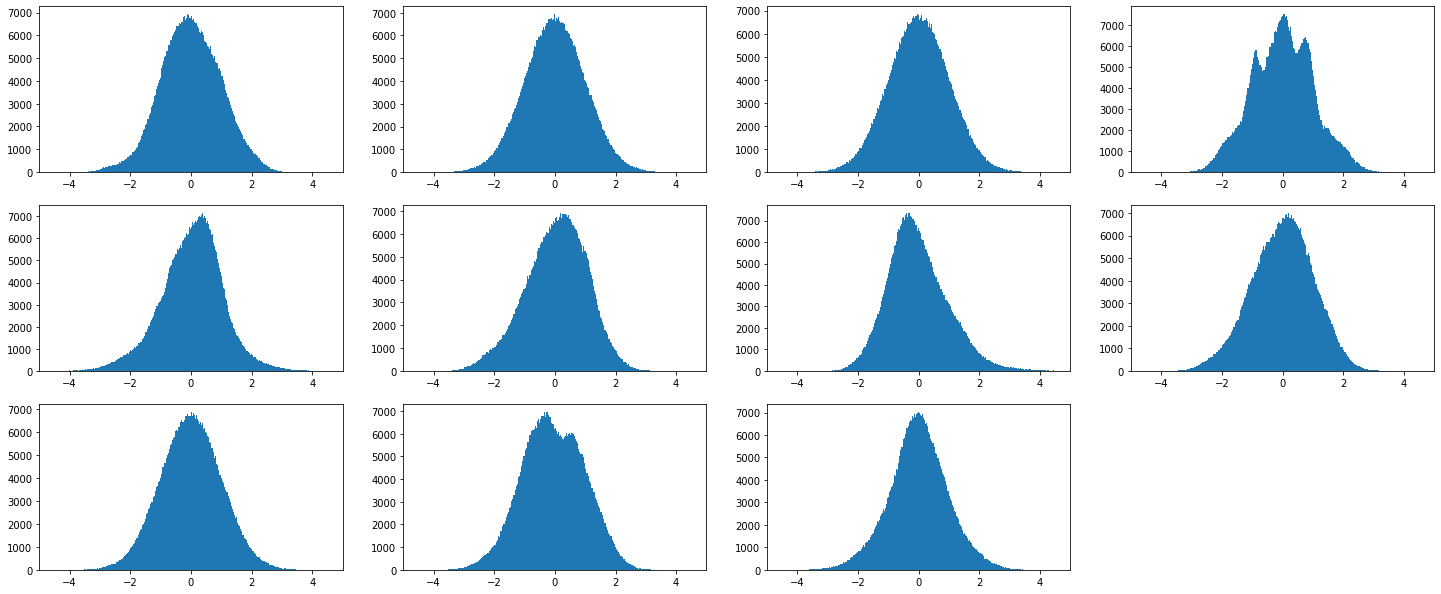

In [11]:

fig = plt.figure(figsize=[25,25])
i = 0

for x in range(hidden.shape[1]):
    axes = fig.add_subplot(7,4,i+1)
    i += 1

    axes.hist(hidden[:, x], bins='auto')
    axes.axis(xmin=-5,xmax=5)
    #axes.title(f"Z{x}")
    print("Mean:", hidden[:, x].mean(), "\tStd:", hidden[:, x].std())


fig.show()

## Bkg Data vs Random Sampling Decoding

In [12]:
# Random sample from N(0,1)
sample = model.decode(torch.rand(bkg.shape[0], study.best_trial.params['hidden_size'])).detach().numpy()

# Make it a dataframe
sample = pd.DataFrame(sample, columns=bkg.columns)
sample.describe()

Electron_Multi    FatJet1_Eta   FatJet1_Mass     FatJet1_PT  \
count   500000.000000  500000.000000  500000.000000  500000.000000   
mean        -0.858293      -0.303853      -0.252998       0.097951   
std          0.015397       0.586334       0.547420       0.468558   
min         -0.935884      -2.539691      -1.505284      -0.796741   
25%         -0.868199      -0.709571      -0.739656      -0.267733   
50%         -0.857703      -0.304322      -0.267041      -0.002704   
75%         -0.847975       0.101770       0.207091       0.339114   
max         -0.219783       1.683023       1.611895       2.502283   

         FatJet1_Phi   FatJet1_Tau1   FatJet1_Tau2   FatJet1_Tau3  \
count  500000.000000  500000.000000  500000.000000  500000.000000   
mean       -0.186983      -0.269944       0.378526       0.507393   
std         0.736547       0.507354       0.642797       0.731098   
min        -1.937918      -1.259678      -0.973755      -1.015350   
25%        -0.681163      -0.716024      -0.182422      -0.138237   
50%        -0.269947      -0.345867       0.284222       0.435236   
75%         0.367545       0.131959       0.874912       1.096831   
max         2.110395       2.023354       2.222489       2.211357   

        FatJet1_Tau4   FatJet1_Tau5  ...    FatJet5_Eta   FatJet5_Mass  \
count  500000.000000  500000.000000  ...  500000.000000  500000.000000   
mean        0.507732       0.497871  ...      -0.006359      -0.013379   
std         0.751299       0.760850  ...       0.015794       0.016638   
min        -1.042009      -1.038198  ...      -0.200535      -0.163046   
25%        -0.158307      -0.178209  ...      -0.016463      -0.024465   
50%         0.439775       0.427846  ...      -0.006175      -0.012525   
75%         1.117258       1.115258  ...       0.003533      -0.001996   
max         2.220088       2.230141  ...       0.150689       0.183306   

          FatJet5_PT    FatJet5_Phi      Muon1_Eta       Muon1_PT  \
count  500000.000000  500000.000000  500000.000000  500000.000000   
mean       -0.000356      -0.000414      -0.289398       0.117343   
std         0.013633       0.016854       0.426128       0.334909   
min        -0.141846      -0.136876      -1.872457      -0.478073   
25%        -0.008771      -0.010102      -0.561658      -0.052629   
50%         0.000651       0.000501      -0.025974      -0.005965   
75%         0.008839       0.010142      -0.002542       0.097194   
max         0.083680       0.177329       0.602103       2.554548   

           Muon1_Phi      Muon2_Eta       Muon2_PT      Muon2_Phi  
count  500000.000000  500000.000000  500000.000000  500000.000000  
mean        0.310833      -0.320707       0.017473      -0.237093  
std         0.624033       0.507557       0.142790       0.849206  
min        -2.059863      -2.326147      -0.612731      -2.192084  
25%        -0.015501      -0.634089      -0.038100      -0.561147  
50%         0.037443      -0.007704      -0.003736      -0.004443  
75%         0.481012       0.011171       0.033753       0.027769  
max         2.415464       1.065508       1.882312       2.197768  

[8 rows x 75 columns]

In [13]:
def plot_graphs2(background, signal, bins=50, num_cols=4, first_name="Signal", second_name="Sampled"):
    WD_SCORE = 0
    R2_SCORE = 0
    # Ignoring irrelevant features such as 'name' and 'weights' in
    # the plotting of the data
    features  = list(background.columns)
    for x in ['name', 'weights']: 
        try:
            features.remove(x)
        except:
            pass

    # Plot creation
    num_rows = int(np.ceil((len(list(background.columns)) - 1) / num_cols)) +1
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(40, 60))
    i= 0

    for x in tqdm(features, total=len(features), desc="Processing..."):

        # Plot  
        row, col = int(i/num_cols), i%num_cols
        #print(row, col, i)
        i += 1


        # Define histogram range
        hist_min = min(signal[x].min(), background[x].min())
        hist_max = max(signal[x].max(), background[x].max())
        hist_range = (hist_min, hist_max)


        ax[row, col].set_title(x)
        ax[row, col].set_yscale('log')
        
        ax[row, col].hist(background[x], bins=bins, alpha=0.5, label=first_name, range=hist_range)
        ax[row, col].hist(signal[x], bins=bins, alpha=0.5, label=second_name,  range=hist_range)
        
        ax[row, col].autoscale(enable=True) 
        ax[row, col].legend()

        WD_SCORE += wasserstein_distance(background[x], signal[x])
        R2_SCORE += r2_score(background[x],signal[x])
        

    fig.tight_layout()
    #plt.savefig('1_explore_data.png', bbox_inches='tight', dpi=100)
    plt.show()
    print("WD_SCORE:", WD_SCORE/len(features))
    print("R2_SCORE:", R2_SCORE/len(features))

Processing...:   0%|          | 0/75 [00:00<?, ?it/s]

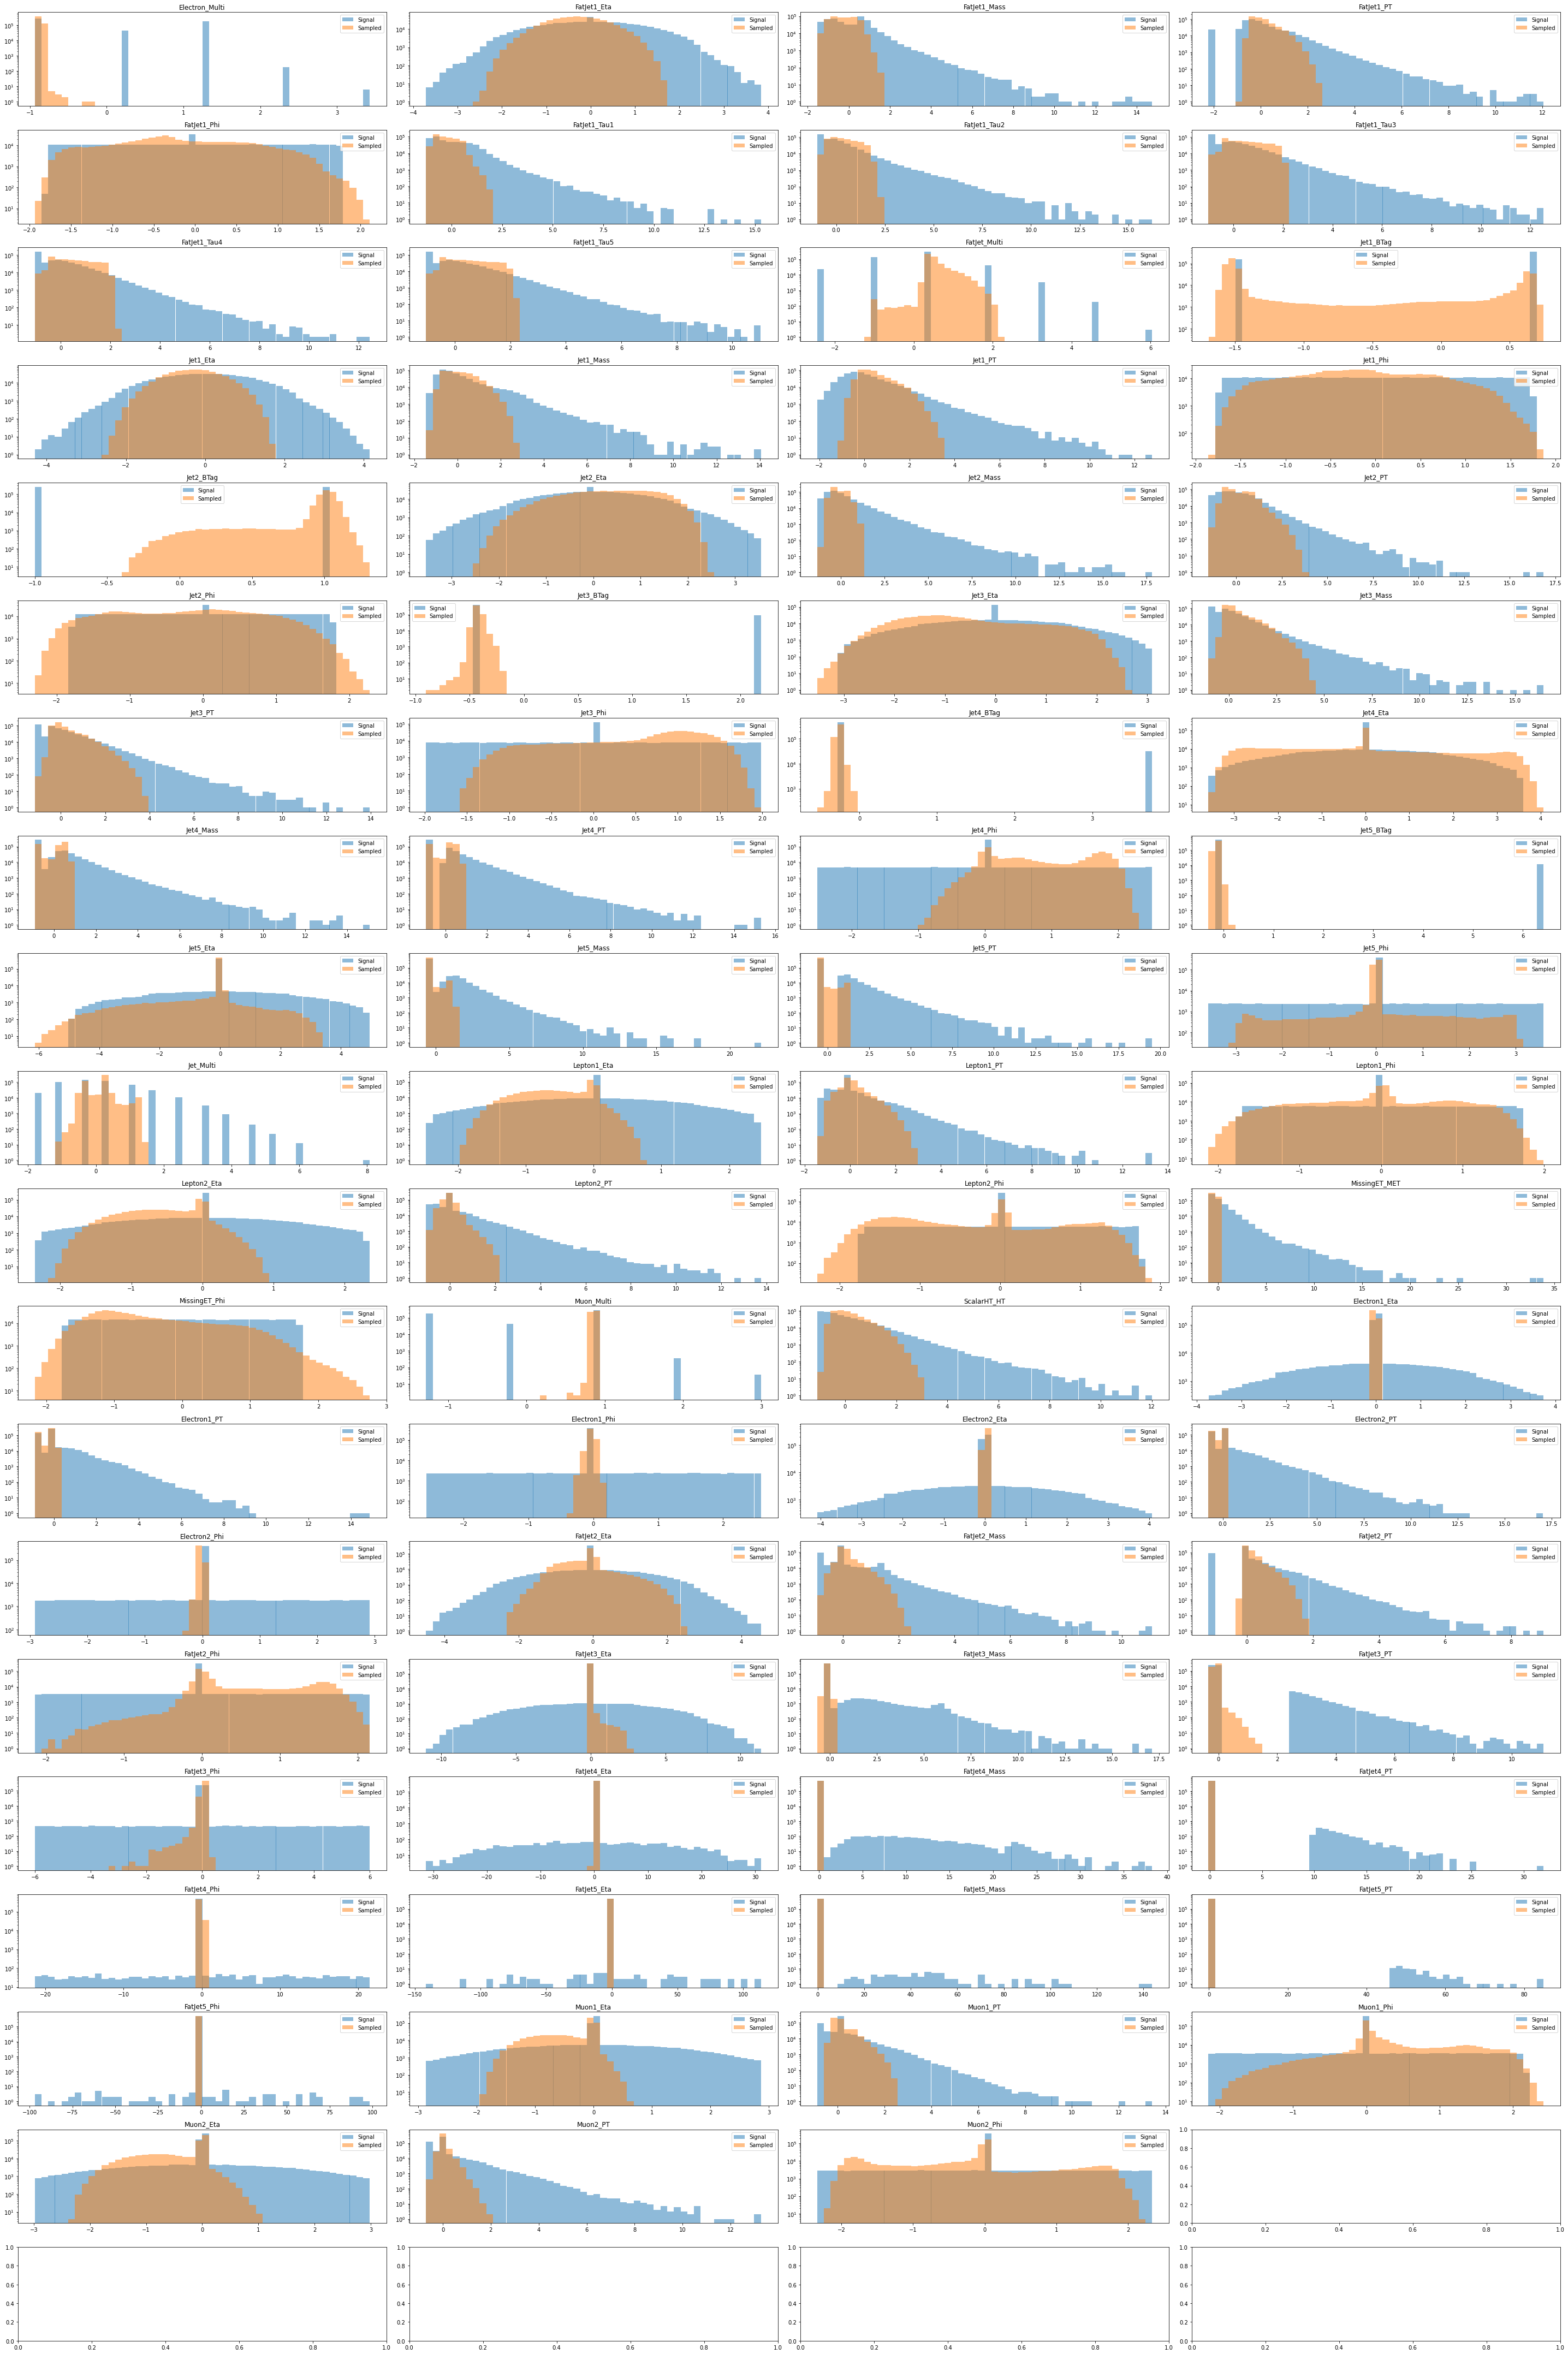

WD_SCORE: 0.3706596306324397
R2_SCORE: -0.4782494031453044


In [14]:
plot_graphs2(bkg, sample)

## Bkg Data vs Reconstruction

In [15]:
def plot_graphs3(first, second, first_name="Signal", second_name="Sampled", bins=50, num_cols=4, num_features=69):

    R2_SCORE = 0

    # Reshape
    first = first.reshape(num_features, -1)
    second = second.reshape(num_features, -1)

    # Plot creation
    num_rows = int(np.ceil((num_features - 1) / num_cols)) +1
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(40, 60))
    i= 0

    for x in tqdm(range(num_features), total=num_features, desc="Processing..."):

        # Plot  
        row, col = int(i/num_cols), i%num_cols
        #print(row, col, i)
        i += 1


        # Define histogram range
        hist_min = min(first[x].min(), second[x].min())
        hist_max = max(first[x].max(), second[x].max())
        hist_range = (hist_min, hist_max)


        ax[row, col].set_title(x)
        ax[row, col].set_yscale('log')
        
        ax[row, col].hist(first[x], bins=bins, alpha=0.5, label=first_name, range=hist_range)
        ax[row, col].hist(second[x], bins=bins, alpha=0.5, label=second_name,  range=hist_range)

        x = x.cpu().numpy()
        output = output.cpu().numpy()

        #print("Input", np.isnan(x).any())
        #print("Output", np.isnan(output).any())


        R2_SCORE += r2_score(first[x],second[x])
        

    fig.tight_layout()
    #plt.savefig('1_explore_data.png', bbox_inches='tight', dpi=100)
    plt.show()
    print("R2_SCORE:", R2_SCORE/num_features)

Processing...:   0%|          | 0/75 [00:00<?, ?it/s]

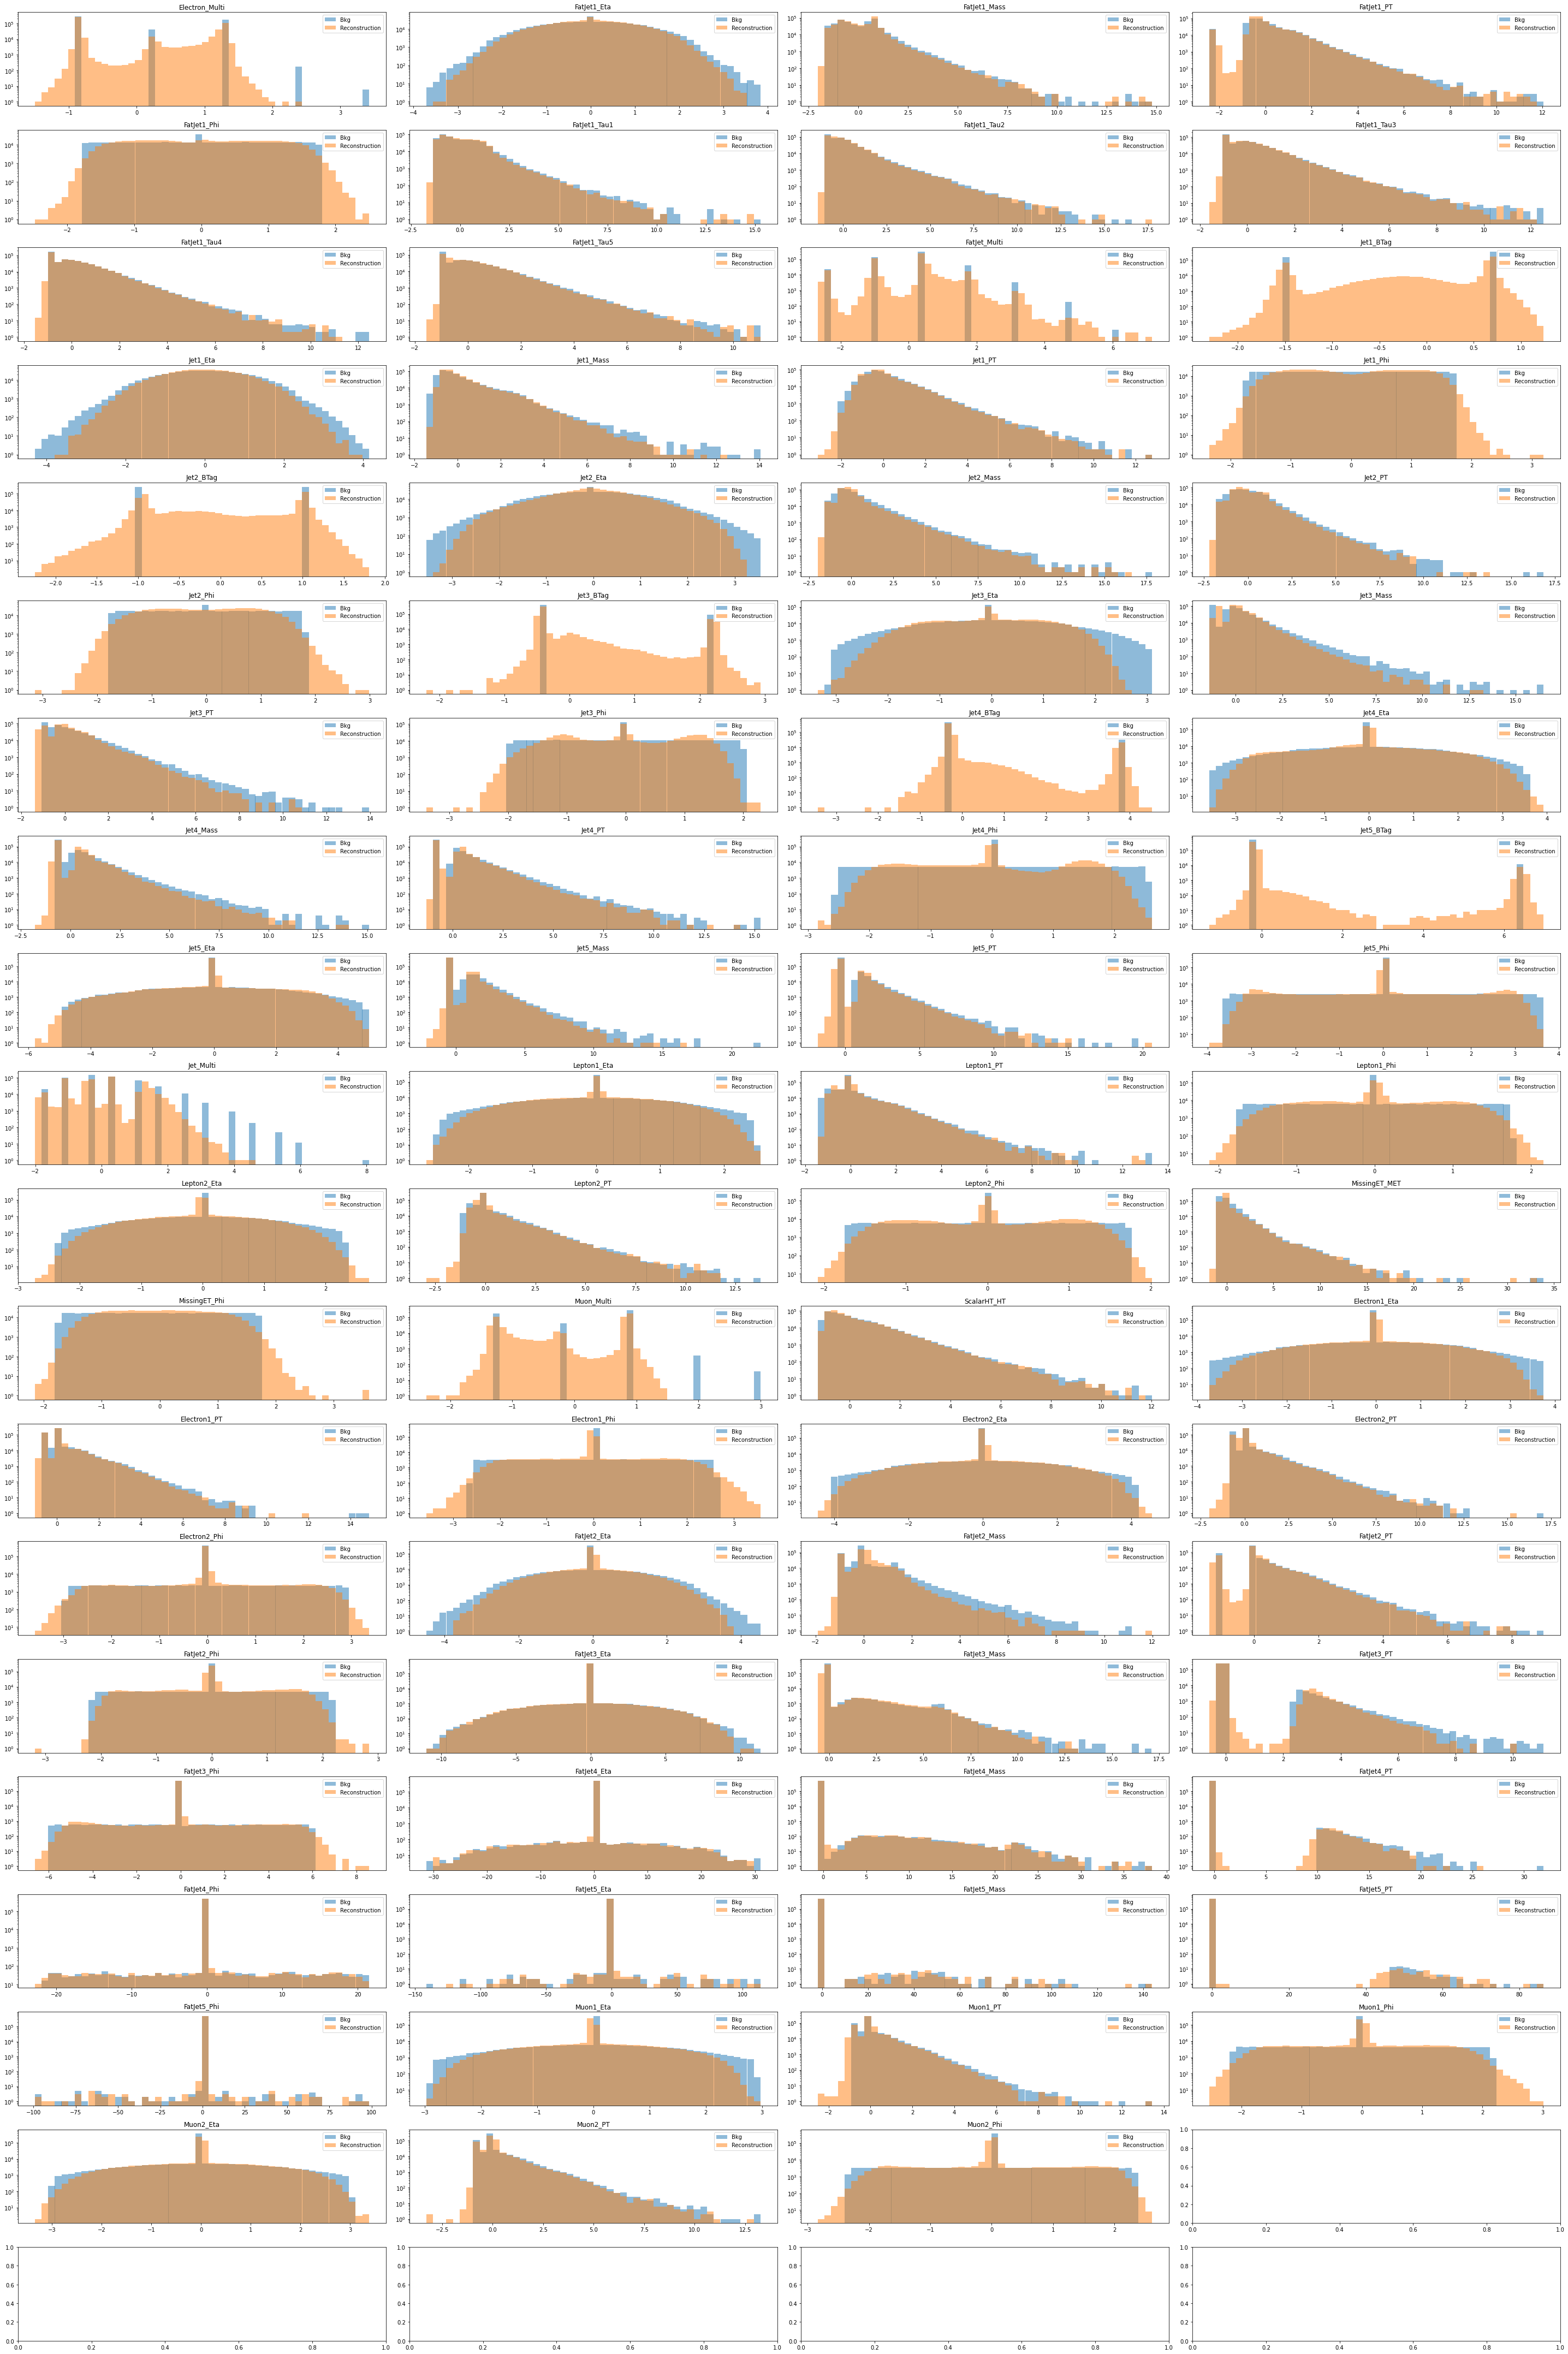

WD_SCORE: 0.07001089949256478
R2_SCORE: 0.8657426568424451


In [17]:
plot_graphs2(bkg, pd.DataFrame(x_out, columns=bkg.columns), first_name="Bkg", second_name="Reconstruction")

Plot latent space

In [18]:
# Sinal
signal, _, signal_name = _dataset(category='all',variant='signal').all_data()
signal['name'] = signal_name

# Bkg
bkg, _, _ = _dataset(category='test',variant='bkg').all_data()
bkg['name'] = 'background.csv'

data = pd.concat([signal, bkg])
del bkg, signal



AttributeError: '_dataset' object has no attribute 'weights'

In [ ]:
fig, ax = plt.subplots( figsize=(10,10))
for x in tqdm(data['name'].unique()):
    mu, log_var, x_out, hidden = model.test_step(torch.from_numpy(data.loc[data['name'] == x].drop(columns=['name']).to_numpy(dtype=np.float32)))
    hidden = hidden.detach().numpy()

    if x != 'background.csv':
        color = None
    else:
        color = 'r'

    ax.scatter(hidden[:1000, 0], hidden[:1000, 1], label=x.replace('.csv', ''), alpha=0.5, edgecolors='none', c = color)

ax.legend()
ax.grid(True)

plt.show()
